Tristan J. Hillis <br/>
ID: 1260315 <br/>
Astro 425 | Late Homework # 5 

In [4]:
%pylab inline

# Other imports
from scipy.integrate import quad
from matplotlib.ticker import AutoMinorLocator
from astropy.io import fits

# style changes
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10.0, 8.0)
mpl.rc('lines', linewidth=1.8, color='k')
mpl.rcParams['font.size'] = 18

def ticks(labelsize, major_size, minor_size):
    mpl.rc('xtick', labelsize=labelsize)
    mpl.rc('xtick.major', size=major_size)
    mpl.rc('xtick.minor', size=minor_size)
    mpl.rc('ytick', labelsize=labelsize)
    mpl.rc('ytick.major', size=major_size)
    mpl.rc('ytick.minor', size=minor_size)
    
ticks(15, 10.0, 5)

Populating the interactive namespace from numpy and matplotlib


In [5]:
class Cosmology():

    def __init__(self, omega_r, omega_m, omega_lambda):
        self.omega_r = omega_r
        self.omega_m = omega_m
        self.omega_lambda = omega_lambda
        self.omega_o = omega_r + omega_m + omega_lambda


    def H_z(self, H, omega_r, omega_m, omega_l, omega_o, z):
        return H * np.sqrt(omega_r * (1.0 + z) ** 4 + omega_m * (1.0 + z) ** 3 + omega_l + (1.0 - omega_o) * (1.0 + z) ** 2)

    def H_t(self, H, omega_r, omega_m, omega_l, omega_o, a):
        return H * np.sqrt(omega_r * a ** -4.0 + omega_m * a ** -3.0 + omega_l + (1 - omega_o) * a ** -2.0)


    def printModel(self):
        print "Omega_r = %.3f, Omega_m = %.3f, Omega_lambda = %.3f, Omega_o = %.3f"%(self.omega_r, self.omega_m, self.omega_lambda, self.omega_o)

    def comovingFrom0toZ(self, zmax, resolution=1000.0):
        H = 2.2683e-18 # hubble constant in s^-1
        z_range = np.linspace(0, zmax, resolution)
        model = lambda z: 299792458.0 / self.H_z(H, self.omega_r, self.omega_m, self.omega_lambda, self.omega_o, z)
        results = np.asarray([quad(model, 0, i)[0] for i in z_range])
        return [z_range, results * 3.24e-23] # return results in Mpc

    def timeFrom0toZ(self, zmax, resolution=1000):
        H = 0.07154 # Hubble's constant in Gyr^-1
        t_0 = 1 / H
        z_range = np.linspace(0, zmax, resolution)
        model_time = lambda z: 1.0 / ((1.0 + z) * self.H_z(H, self.omega_r, self.omega_m, self.omega_lambda, self.omega_o, z))
        lookBack = np.asarray([quad(model_time, 0, i)[0] for i in z_range])
        age = t_0 - np.asarray([quad(model_time, 0, i)[0] for i in z_range])
        return [z_range, lookBack, age]

    def calcComovingForZ(self, zmin, zmax):
        H = 2.2683e-18 # hubble constant in s^-1
        model = lambda z: 299792458.0 / self.H_z(H, self.omega_r, self.omega_m, self.omega_lambda, self.omega_o, z)
        results = quad(model, zmin, zmax)[0]
        return results * 3.24e-23 # return results in Mpc

    def calcAgeForZ(self, z):
        H = 0.07154 # Hubble's constant in Gyr^-1
        t_0 = 1.0 / H
        model_time = lambda z: 1.0 / ((1.0 + z) * self.H_z(H, self.omega_r, self.omega_m, self.omega_lambda, self.omega_o, z))
        results = t_0 - quad(model_time, 0, z)[0]
        return results

    def angularDist(self, zmin, zmax):
        r = self.calcComovingForZ(zmin, zmax)
        return (r / (1.0 + (zmax-zmin)))

    def timeFrom0toa(self, amax):
        H = 0.07154 # Hubble's constant in Gyr^-1
        model_time = lambda a: 1.0 / (a * self.H_t(H, self.omega_r, self.omega_m, self.omega_lambda, self.omega_o, a))
        results = quad(model_time, 0, amax)[0]
        return results

    def calcAgeForA(self, amin, amax):
        H = 0.07154 # Hubble's constant in Gyr^-1
        model_time = lambda a: 1.0 / (a * self.H_t(H, self.omega_r, self.omega_m, self.omega_lambda, self.omega_o, a))
        results = quad(model_time, amin, amax)[0]
        return results

    def calcAgeForRangeOfA(self, amin, amax, resolution=500):
        H = 0.07154 # Hubble's constant in Gyr^-1
        t_0 = 1.0 / H
        a_range = np.linspace(amin, amax, resolution)
        model_time = lambda a: 1.0 / (a * self.H_t(H, self.omega_r, self.omega_m, self.omega_lambda, self.omega_o, a))
        lookBack = np.asarray([quad(model_time, amin, i)[0] for i in a_range])
        age = t_0 - np.asarray([quad(model_time, amin, i)[0] for i in a_range])
        return [a_range, lookBack, age]


# Problem 1
**Part a:**  There are a number of ways we can constrain the problem of finding one of the best representations of a loitering universe.  First off, from Ryden Figure 6.3 we can see that a loitering universe has to consist of a positive curvature $\kappa=1$, which is to say that $(1-\Omega_0)>0$.  Meaning values of a negative lambda constant will likely not result in a loitering universe.  We then opt for a greater than 0 lambda constant.  Furthermore, radiation shouldn't have a big contribution since this is only a small part in the early universe whereas we care more about the transition from matter dominated to lambda dominated.  We therefore constrain to small $\Omega_r$ and moderate $\Omega_m$, where $\Omega_m$ will likely need to be greater than the Benchmark model to cause that "loitering" effect.  Before we run a "minimization" We play around further with smaller $\Omega_\Lambda$ and find that values greater than one present the best results.  The following range in values is used in a minimization with runtime of $\mathcal{O}(N^3)$:
$0 \leq \Omega_r\leq 1 $, $0.4 \leq\Omega_m \leq 1$, and $1 \leq \Omega_\Lambda\leq 2.5$.

To minimize this problem within the constrains we have set out, we determine the gradient of the scale factor $a(t)$, wherein the minimum value will correspond to the flattest "loitering" part as $a(t)$ becomes constant for a time.


**Part b:**  We can perform a similar minimization on the big crunch universe by looking for the smallest gradient that would represent the flattest peak on the parabolic big crunch profile.  To start we need to consider how we can constrain this problem.  From Ryden Figure 6.3 we know that the big crunch can happen over any curvature type which leaves this problem more open.  We also can tell from the same figure that we need a zero, or nearly zero $\Omega_\Lambda$ value, which makes sense since this is the constant that dictates an acceleration.  The biggest factor in a big crunch will be the mass considering that the gravity from the mass will be the thing to pull things back together.  I then take on the following ranges as a guess: $0 \leq \Omega_r\leq 1$, $0.5 \leq\Omega_m \leq 8$, and $0 \leq \Omega_\Lambda\leq 0.2$.

The code below shows the minimization and the plots for the loitering and big crunch universes.

In [ ]:
# Code for part a: Outputs a file full of the smallest gradient with the corresponding omega values.
# Note that it takes a while to run but off screen we can run the file and find the best answer.  
# Those happen to be The best find was with parameters of Omega_r = 0.0, Omega_m = 0.45217, Omega_l = 1.93478, and
# with a minimum gradient of a_grad =  0.00935. The below cell runs this answer and plots it along with the gradient.

# loitering universe a is constant so we can check to see if time changes as it stays constant
r_range = np.linspace(0, 1, 5)
m_range = np.linspace(0.4, 1, 70)
l_range = np.linspace(1, 2.5, 70)
amax = 6

f = open('loiter.txt', 'w')


for i in r_range:
    for j in m_range:
        for k in l_range:
            model2 = Cosmology(i, j, k)
            results = model2.calcAgeForRangeOfA(0.001, amax, resolution=30)
            gradient_time = np.gradient(results[1])
            gradient_a = np.gradient(results[0], gradient_time)
            #print i, j, k, gradient_a.min()
            if not np.isnan(gradient_a.min()):
                f.write('%.5f\t%.5f\t%.5f\t%.5f\n'%(gradient_a.min(), i, j, k))


Minimized Gradient: 0.00219818622884
Cosmology: Omega_r = 0.000, Omega_m = 0.452, and Omega_l = 1.935


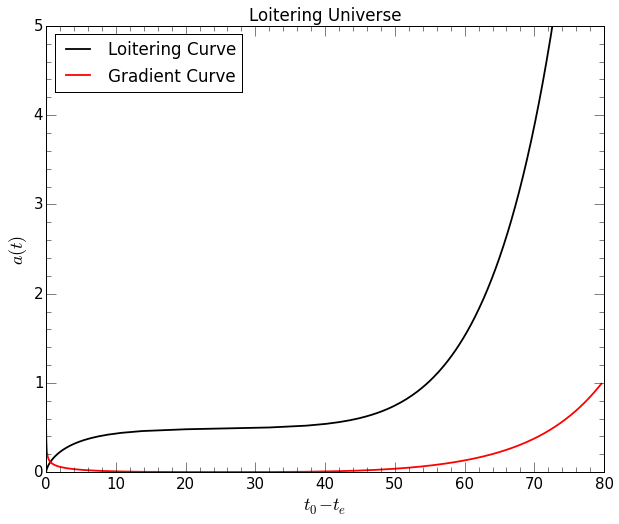

In [19]:
# Plot for part a:

model = Cosmology(0.0, 0.45217, 1.93478)
results = model.calcAgeForRangeOfA(0.0001, 10.0)
#print results[1]


gradient_time = np.gradient(results[1])
gradient_a = np.gradient(results[0], gradient_time)


print "Minimized Gradient:",gradient_a.min()
print "Cosmology: Omega_r = %.3f, Omega_m = %.3f, and Omega_l = %.3f"%(model.omega_r, model.omega_m, model.omega_lambda)

plt.plot(results[1], results[0], color='k', label="Loitering Curve")
plt.plot(results[1], gradient_a, color='r', label="Gradient Curve")



plt.title("Loitering Universe")
plt.xlabel(r"$t_0 - t_e$", fontsize=18)
plt.ylabel(r"$a(t)$", fontsize=18)
plt.ylim([0,5])
plt.legend(loc=0)

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5))


In [23]:
# Code for part b: This is the minimization section, and note that this takes a long time to run so we filter the file
# output to the side to simply find the min gradient value.  We can also use the fact that once the big crunch has reached
# its peak the numerical integration return 'nan' back as the integral can obviously not be evaluated past it' max. 
# This fact tells us we indeed have a plausible big crunch rather than some slow climb in scale length.

def filterNan(array):
    return array[~np.isnan(array)]

r_range = np.linspace(0, 1, 50)
m_range = np.linspace(0.5, 8, 80)
l_range = np.linspace(0, 0.2, 10)

amax = 10


f = open('crunch.txt', 'w')


for k in l_range:
    for j in m_range:
        for i in r_range:
            model2 = Cosmology(i, j, k)
            results = model2.calcAgeForRangeOfA(0.001, amax, resolution=50)
            gradient_time = np.gradient(results[1])
            gradient_a = np.gradient(results[0], gradient_time)
            grad_min = filterNan(gradient_a).min()
            #print i, j, k, grad_min
            if np.any(np.isnan(results[1])):
                f.write('%.5f\t%.5f\t%.5f\t%.5f\n'%(grad_min, i, j, k))

f.close()



Min Gradient of a(t): 0.00125976775615
Cosmology: Omega_r = 0.388, Omega_m = 0.690, and Omega_l = 0.000


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in sqrt


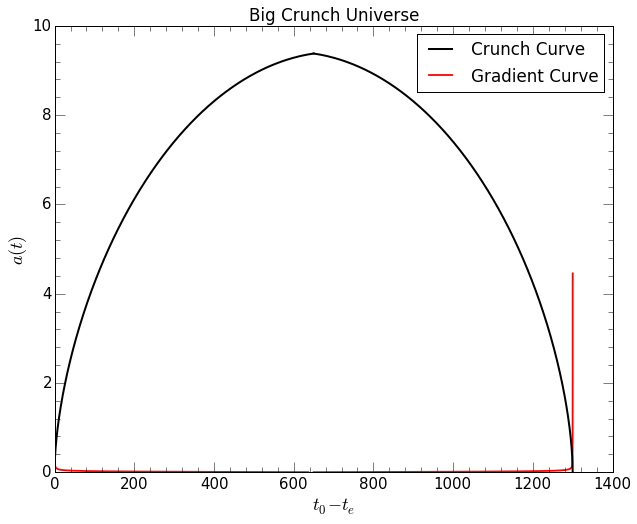

In [39]:
# Plot for part b:  After finding the our answer in the text file we get a universe with the parameters: 
# Omega_r = 0.38776, Omega_m = 0.68987, Omega_l = 0.0, and a minimum gradient of a_grad = 0.00281.

def getIndicesOfNan(array):
    return np.where(~np.isnan(array))

model = Cosmology(0.38776, 0.68987, 0.0)
a_range, lookback, age = model.calcAgeForRangeOfA(0.0001, 10)

#print lookback
gradient_time = np.gradient(lookback)
gradient_a = np.gradient(a_range, gradient_time)

# nan values screw with .min() so we have to filter them out.
nan_idx = getIndicesOfNan(gradient_a)
gradient_a = gradient_a[nan_idx]
a_range = a_range[nan_idx]
lookback = lookback[nan_idx]
age = age[nan_idx]


lookback_sym =  2 * lookback[-1] - lookback




threshold = 0.015

print "Min Gradient of a(t):",gradient_a.min()
if(gradient_a.min() <= threshold):
    print "Cosmology: Omega_r = %.3f, Omega_m = %.3f, and Omega_l = %.3f"%(model.omega_r, model.omega_m, model.omega_lambda)

# Have to kind of 'hack' the plot and the results are not the best looking towards the peak.
plt.plot(lookback, a_range, color='k', label='Crunch Curve', zorder=2, linewidth=2.0)
plt.plot(lookback_sym, a_range, color='k', zorder=2, linewidth=2.0)

plt.plot(lookback, gradient_a, color='r', label="Gradient Curve",zorder =1)
plt.plot(lookback_sym, gradient_a, color='r',zorder =1)


plt.title("Big Crunch Universe")
plt.xlabel(r"$t_0 - t_e$", fontsize=18)
plt.ylabel(r"$a(t)$", fontsize=18)
plt.ylim([0,10])
plt.legend(loc=0)

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(5))


# Problem 2

I start with looking at the Einstein ring in the lens equation where $\beta = \theta - \frac{\theta_E^2}{\theta}$ and $\beta=0$ here.  This gives $\theta^2 = \theta_E^2$ where $\theta_E^2$ is the following: $$\theta_E^2 = \frac{4GMD_{ls}}{c^2 D_l D_s}$$
This gives: $$\theta^2 =\frac{4GMD_{ls}}{c^2 D_l D_s}$$
We can think of an image that is right on the Einstein ring which entails $\theta=\tan\left(\frac{r_E}{D_l}\right)$ where $\theta$ becomes  $\theta=\frac{r_E}{D_l}$  by small angle approximation.
Substiting into our above lens equation gives: $$r_E^2 = \frac{4GMD_{ls}D_l}{c^2 D_s}$$
This is the Einstein radius.  The total mass within that Einstein radius is then: $$M = \frac{r_E^2 D_s c^2}{4G D_{ls}D_l}$$
We can thusly relate this mass with the density of an isothermal sphere whose radius is that of the Einstein radius.  This gives: $$\rho(r_E) = \frac{M}{V}=\frac{r_E^2 D_s c^2}{4GD_l D_{ls}}\left(\frac{3}{4 \pi r_E^3}\right)$$
This leads to the relation with the isothermal sphere as: $$\frac{3D_s c^2}{16 G r_E \pi D_l D_{ls}}=\frac{\sigma_v^2}{2 \pi G r_E^2}$$
Reducing gives: $$\sigma_v^2=\frac{3 r_E D_s c^2}{8D_l D_{ls}}$$
Again we use the relation that $r_E=\theta D_l$ which gives: $$\sigma_v^2=\frac{3 \theta D_s c^2}{8 D_{ls}}$$
Which will finally reduce to our answer: $$\boxed{\sigma_v \approx 10^3 km/s\ \left(\frac{\theta}{28''}\frac{D_s}{D_{ls}} \right)^{1/2}}$$